# The "Jared Is Miserable" (JIM) Index
## Written by Jared Rennie (@jjrennie)
> "Misery, she needs me, but I need her more"
> --- Metallica

If you're looking for a metric to objectively decide good weather days from bad, then you're at the wrong place. I'd suggest checking out someone else's site like [this one](https://www.cbsnews.com/boston/news/how-many-top-10-weather-days-do-we-get-in-boston/)

This notebook creates times in the Contiguous US where Jared would be miserable. After extensive analysis and peer-review research, the "JIM" is defined as the following:

$Td>=55°F$

Because it's literally not the heat, it's the humidity! This notebook utilizes the [High-Resolution Rapid Refresh (HRRR)](https://rapidrefresh.noaa.gov/hrrr/) model stored in AWS in ZARR format. This is maintained by MesoWest, and their description of HRRR in ZARR format is [here](https://mesowest.utah.edu/html/hrrr/)

### What You Need

First off, the entire codebase works in Python... sort of. 

You will need the following programs installed: 
- Python
- s3fs | numpy | xarray | matplotlib | cartopy | h5netcdf | h5py | zarr | metpy
    
The "easiest" way is to install these is by installing <a href='https://www.anaconda.com/' target="_blank">Anaconda</a>, and then applying <a href='https://conda-forge.org/' target="_blank">conda-forge</a>. Afterward, then you can install the above packages. 

### Import Packages

In [1]:
# Import Packages
import sys, time, datetime, os
import numpy as np
import xarray as xr
import s3fs
import metpy

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

%matplotlib inline
print("SUCCESS")

SUCCESS


If you made it this far, great!

### Input Parameters
This is where you will put in some information to help with the plotting, including:

- Which HRRR model run you want (note that times are in UTC)
- Which element (in this case, it's dewpoint 2m above ground, and shouldn't be changed
- Which forecast hour you want (only 1 provided in this notebook)
- Author's name (because Jared may be miserable, but they may have not made this particular plot)

In [2]:
# Get Date Info for Use with HRRR
year= "2024"
month= "08"
day= "20"
hour = "15"
date = year+month+day
init_name=year+month+day+': '+hour+'UTC'
init_time=year+month+day+hour

# Indicate Forecast Hour
fcstHR=1
time_counter=fcstHR-1

# Get Element Info for use with HRRR
var = 'DPT'
level = '2m_above_ground'

# Indicate Author
author='Not Jared Rennie'

# Print Out Results
print("Model Initialized: ",init_name)
print("Forecast Hour: ",int(fcstHR))
print("Author: ",author)

Model Initialized:  20240820: 15UTC
Forecast Hour:  1
Author:  Not Jared Rennie


### Read in data, stored in AWS as ZARR format

This block will read in the data, stored in the cloud via an [AWS bucket](https://aws.amazon.com/marketplace/pp/prodview-yd5ydptv3vuz2#resources). 

In [3]:
# Access HRRR from AWS ... projection dimensions are in url2
fs = s3fs.S3FileSystem(anon=True)
url1 = 's3://hrrrzarr/sfc/' + date + '/' + date + '_' + hour + 'z_fcst.zarr/' + level + '/' + var + '/' + level
url2 = 's3://hrrrzarr/sfc/' + date + '/' + date + '_' + hour + 'z_fcst.zarr/' + level + '/' + var

file1 = s3fs.S3Map(url1, s3=fs)
file2 = s3fs.S3Map(url2, s3=fs)

# Open Datasets
print("\nOPEN FORECAST DATASETS")
print ("\t",url1)
print ("\t",url2)
ds = xr.open_mfdataset([file1,file2], engine='zarr')

print("SUCCESS")


OPEN FORECAST DATASETS
	 s3://hrrrzarr/sfc/20240820/20240820_15z_fcst.zarr/2m_above_ground/DPT/2m_above_ground
	 s3://hrrrzarr/sfc/20240820/20240820_15z_fcst.zarr/2m_above_ground/DPT
SUCCESS


Let's see what the dataset looks like

In [4]:
ds

<xarray.Dataset>
Dimensions:                  (time: 18, projection_y_coordinate: 1059,
                              projection_x_coordinate: 1799)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
  * time                     (time) datetime64[ns] 2024-08-20T16:00:00 ... 20...
Data variables:
    DPT                      (time, projection_y_coordinate, projection_x_coordinate) float32 dask.array<chunksize=(18, 150, 150), meta=np.ndarray>
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(18,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] ...

### Build the JIM
This block will extract the dewpoint data from HRRR, convert it to degrees Fahrenheit, and then search for points the value is greater than some sort of threshold (here defined as 55). There is absolutely, positively no reason to change this threshold. It's Science!

In [5]:
# Get Dewpoint Data (and the associated JIM)
JIM_Thresh=55

airTd = ds[var][time_counter].metpy.convert_units('degF')
JIM=np.where(airTd.values >= JIM_Thresh, 1, 0)

JIM

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

Result is a 2D array of 1's and 0's....the locations where Jared is (and isn't) miserable.

Now for the fun part...

### Plot the JIM
This block of code generates the plot. Feel free to change as you see fit. Although it's considered a masterpiece to some.


PLOT
	T=  01 :  20240820: 16UTC


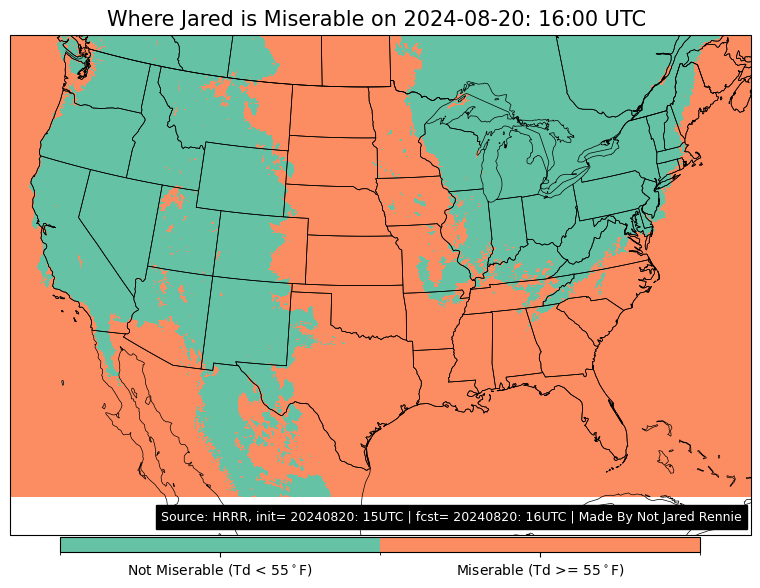

In [6]:
#####################
# Plot Forecast Hour
#####################
print("\nPLOT")

# Set Plotting Bounds
dpi=100
minLat = 22    
maxLat = 50   
minLon = -120 
maxLon = -73 

# Format Time Information for plotting.
fcstTime=ds.time.values[time_counter]
fcstYear= "%04i" % int(fcstTime.astype('datetime64[h]').astype(str)[0:4])
fcstMonth="%02i" % int(fcstTime.astype('datetime64[h]').astype(str)[5:7])
fcstDay="%02i" % int(fcstTime.astype('datetime64[h]').astype(str)[8:10])
fcstHour="%02i" % int(fcstTime.astype('datetime64[h]').astype(str)[11:13])
    
forecast_name=fcstYear+fcstMonth+fcstDay+': '+fcstHour+'UTC'
forecast_time=fcstYear+'-'+fcstMonth+'-'+fcstDay+': '+fcstHour+':00 UTC '
forecast_hour= "%02i" % (time_counter+1)
print("\tT= ",forecast_hour,": ",forecast_name)

# Get Plotting Coordinates
x = airTd.projection_x_coordinate
y = airTd.projection_y_coordinate

# Define HRRR projection
lon1 = -97.5
lat1 = 38.5
slat = 38.5
projData= ccrs.LambertConformal(central_longitude=lon1,central_latitude=lat1,standard_parallels=[slat])

# Set Up Figure
fig= plt.figure(num=1, figsize=(8,5), dpi=dpi, facecolor='w', edgecolor='k')
ax = fig.add_axes([0, 0, 1, 1], projection=projData)
ax.set_extent([minLon, maxLon, minLat, maxLat], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'),linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('50m'),linewidth=0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'),linewidth=0.5)

# Plot Data
cmap = mcolors.ListedColormap(['#66c2a5','#fc8d62'])
ax.pcolormesh(x, y, JIM,cmap=cmap)

# Add Colormap
bounds = np.arange(cmap.N+1) 
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cax = fig.add_axes([0.1, -0.035, 0.8, 0.03])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cax, boundaries=bounds, ticks=bounds, spacing='uniform', orientation='horizontal')
cbar.ax.tick_params(labelsize=10)

# Define tick locations and labels
labels=np.array(['Not Miserable (Td < 55$^\circ$F)','Miserable (Td >= 55$^\circ$F)'],dtype='str')
tick_locations = np.arange(0.5, float(len(labels)+0.5), 1)  # Adjust the number of tick locations to match the number of boundaries
cbar.set_ticks(tick_locations)
cbar.set_ticklabels(labels,color='black')
cbar.ax.tick_params(labelsize=10)

# Add Titles
plt.suptitle('Where Jared is Miserable on '+forecast_time,fontsize=15,y=1.05,color='black')
plt.annotate('Source: HRRR, init= '+init_name+' | fcst= '+forecast_name+' | Made By '+author,xy=(1.065, 1.91), xycoords='axes fraction', fontsize=9,backgroundcolor='black',color='white',horizontalalignment='right', verticalalignment='bottom')

# Save Figure
plt.show()

Isn't it beautiful?

**Congrats on completing this notebook! Now go forth and make better plots**